### Text Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb_sample/texts.csv')]

In [3]:
df = pd.read_csv(path / 'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Unlike images that can be fed directly in to a model, text must be pre-processed so that mathematical functions can use them. This is done in two steps: tokenization, and numericalization.

A `TextDataBunch` does this for you automatically.

In [9]:
data = (TextList
           .from_csv(path, 'texts.csv', cols='text')
           .split_from_df(col=2)
           .label_from_df(cols=0)
           .databunch())

In [11]:
type(data).__bases__

(fastai.text.data.TextDataBunch,)

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [13]:
data.train_ds[0][0]

Text xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

In [15]:
data.train_ds[0][0].data[:10]

array([   2,    5, 4619,   25,    0,   25,  867,   52,    5, 3776])

### Language Model

NLP tasks involve training two models. We first fine-tune a model pretrained on the English of Wikipedia, and this model serves as our domain-specific language model. Using that, we will then train a classifier.

In [9]:
path = untar_data(URLs.IMDB)

In [10]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/unsup'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/README'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/test'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train')]

In [11]:
data_lm = (TextList
              .from_folder(path)
              .filter_by_folder(include=['train', 'test', 'unsup'])
              .split_by_rand_pct(0.1)
              .label_for_lm()
              .databunch(bs=48))

In [12]:
data_lm.save('data_lm.pkl')

In [13]:
data_lm = load_data(path, 'data_lm.pkl', bs=48)

In [14]:
data_lm.show_batch()

idx,text
0,"is 30s pulp fiction . xxmaj it is adventure . xxmaj it is comedy . xxmaj and for the most part , it is a brilliant piece of work . \n \n xxmaj when xxmaj buckaroo discovers that aliens from another dimension are infiltrating our world , he and his intrepid band of engineers and scientists go on the job to investigate and correct the dangerous situation . xxmaj"
1,"welles as a goofy sheik who speaks in fractured fragmented sentences , xxmaj bill xxmaj forsythe as a brutish caveman football player , xxmaj rance xxmaj howard as a fanatically gung - ho high school football coach , and xxmaj angelo xxmaj rossitto as an excitable midget hotel desk clerk . xxmaj overall , this baby measures up as a pretty solid and satisfying so - dumb - it's -"
2,"his head , in his secret xxmaj manhattan apartment , just like the other two murder victims . xxmaj so much for xxmaj raymond 's honesty . xxmaj well paced and stylish murder mystery drama with xxmaj al xxmaj pacino giving one of his best performances as xxmaj det . xxmaj keller , a deeply depressed and fatalistic man , who 's only reason for living is his job as"
3,"or if not , they are visually exciting . xxmaj beauty and the xxmaj beast is by far one of xxmaj disney 's best . xxmaj it 's an adorable story with romance , comedy , and a little slapstick action . xxmaj the characters are really well developed , particularly xxmaj belle , the xxmaj beast and the many implements of the house that play significant roles . xxmaj"
4,"the flashbacks ( the movie is basically one big flashback , as well ) is at least one case of a flashback within the flashback . xxmaj or is that three layers ? xxmaj brilliance beget by necessity . xxbos xxup into xxup great xxup silence is more a sleep aid than a documentary . i think a more appropriate title would 've been xxmaj into xxmaj great xxmaj boredom"


In [16]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)  # drop_mult sets the amount of dropout. this will be covered in the future.

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


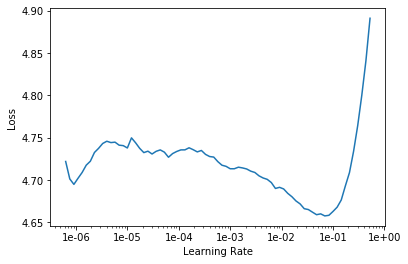

In [19]:
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))  # moms is momentums, something to do with 1cycle policy

epoch,train_loss,valid_loss,accuracy,time
0,4.155874,4.018259,0.295883,15:50


In [22]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

In [25]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.880252,3.838674,0.313961,16:08
1,3.828766,3.796330,0.320927,16:05
2,3.821945,3.770662,0.324428,16:10


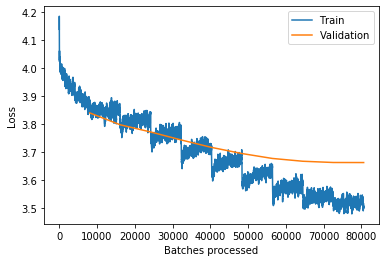

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save('stage-2')

In [35]:
learn.save_encoder('stage-2-enc')

In [41]:
learn.validate()

[3.6613464, tensor(0.3382)]

This means that our model is predicting the next word correctly 33.8% of the time. Pretty sweet!

In [40]:
learn.predict('I liked this movie because', 40, temperature=0.75)  # less temp means less randomized text

'I liked this movie because of the cinematography that i saw in the movie . The visual effects were very good and the movie was worth watching . The actors were good in their roles . The sets and costumes were great'

### Classifier

Now that we've created our language model, it's time to construct our classifier model.

In [47]:
data_clas = (TextList
                .from_folder(path, vocab=data_lm.vocab)  # vocab is from the langugage model above
                .split_by_folder(valid='test')
                .label_from_folder(classes=['pos', 'neg'])
                .databunch(bs=48))

In [48]:
data_clas.save('data_clas.pkl')

In [49]:
data_clas = load_data(path, 'data_clas.pkl', bs=48)

In [50]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n \n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first",neg
"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact ,",pos
"xxbos xxmaj to be a xxmaj buster xxmaj keaton fan is to have your heart broken on a regular basis . xxmaj most of us first encounter xxmaj keaton in one of the brilliant feature films from his great period of independent production : ' xxmaj the xxmaj general ' , ' xxmaj the xxmaj navigator ' , ' xxmaj sherlock xxmaj jnr ' . xxmaj we recognise him as",neg
"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his deserts . xxmaj it is , in fact , one of the things that has made the character of xxmaj dirty xxmaj harry xxmaj callahan ( as played by xxmaj clint xxmaj eastwood ) so popular",pos


In [52]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('stage-2-enc');  # this is encoder we save from language model

In [53]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


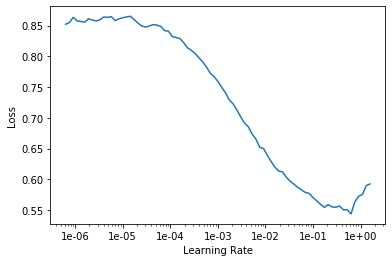

In [54]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.329315,0.258224,0.895400,03:15


We have an 89% accuracy in detecting whether a review is negative or positive with just 3 minutes of training.

In [56]:
learn.save('clas-1')

In [60]:
learn.load('clas-1');

With text classification tasks, it helps to unfreeze one layer at a time, and not to unfreeze the whole thing.

In [61]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.296523,0.217580,0.915120,03:23


In [62]:
learn.save('clas-2')

In [64]:
learn.load('clas-2');

In [65]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.235517,0.187230,0.929360,03:23


In [66]:
learn.save('clas-3')

In [69]:
learn.load('clas-3');

Now we unfreeze the entire thing

In [70]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.205021,0.176165,0.933920,03:34
1,0.182655,0.172687,0.935000,03:39


So an overall accuracy of 93.5%

In [71]:
learn.predict("This movie is probably not worth your money")

(Category neg, tensor(1), tensor([0.0064, 0.9936]))

### Notes
* `moms=(0.8, 0.7)` is will be covered later. It helps to decrease momentum a little when training RNNs.
* Why is learning rate various things divided by `2.6 ** 4`? 

```
Good question. So the learning rate is various things divided by 2.6 to the fourth. The reason it's to the fourth, you will learn about at the end of today. So let's focus on the 2.6. Why 2.6? Basically, as we're going to see in more detail later today, this number, the difference between the bottom of the slice and the top of the slice is basically what's the difference between how quickly the lowest layer of the model learns versus the highest layer of the model learns. So this is called discriminative learning rates. So really the question is as you go from layer to layer, how much do I decrease the learning rate by? And we found out that for NLP RNNs, the answer is 2.6.

How do we find out that it's 2.6? I ran lots and lots of different models using lots of different sets of hyper parameters of various types (dropout, learning rates, and discriminative learning rate and so forth), and then I created something called a random forest which is a kind of model where I attempted to predict how accurate my NLP classifier would be based on the hyper parameters. And then I used random forest interpretation methods to basically figure out what the optimal parameter settings were, and I found out that the answer for this number was 2.6. So that's actually not something I've published or I don't think I've even talked about it before, so there's a new piece of information. Actually, a few months after I did this, Stephen Merity and somebody else did publish a paper describing a similar approach, so the basic idea may be out there already.

Some of that idea comes from a researcher named Frank Hutter and one of his collaborators. They did some interesting work showing how you can use random forests to actually find optimal hyperparameters. So it's kind of a neat trick. A lot of people are very interested in this thing called Auto ML which is this idea of like building models to figure out how to train your model. We're not big fans of it on the whole. But we do find that building models to better understand how your hyper parameters work, and then finding those rules of thumb like oh basically it can always be 2.6 quite helpful. So there's just something we've kind of been playing with.
```